히스토그램 = 이미지 픽셀값의 분포를 나타낸다.

픽셀값의 분포가 서로 비슷하다 == 유사한 이미지일 확률이 높다.

분포가 서로 다르다 == 서로 다른 이미지일 확률이 높다.

cv2.compareHist(hist1, hist2, method)


hist1, hist2: 비교할 두 개의 히스토그램, 크기와 차원이 같아야 함


method: 비교 알고리즘

#### method param에 해당하는 값들

cv2.HISTCMP_CORREL: 상관관계 (1: 완전 일치, -1: 완전 불일치, 0: 무관계)


cv2.HISTCMP_CHISQR: 카이제곱 (0: 완전 일치, 무한대: 완전 불일치)


cv2.HISTCMP_INTERSECT: 교차 (1: 완전 일치, 0: 완전 불일치 - 1로 정규화한 경우)

In [1]:
import cv2, numpy as np
import matplotlib.pylab as plt

In [2]:
img1 = cv2.imread('./RC/1.jpg')
img2 = cv2.imread('./RC/2.jpg')
img3 = cv2.imread('./RC/3.jpg')
img4 = cv2.imread('./RC/4.jpg')
img4 = cv2.imread('./RC/5.jpg')

CORREL    	img1:   1.00	img2:   1.00	img3:   0.98	img4:   1.00	
CHISQR    	img1:   0.00	img2:   0.96	img3: 228.50	img4: 132.02	
INTERSECT 	img1:   1.00	img2:   0.84	img3:   0.75	img4:   0.91	
BHATTACHARYYA	img1:   0.00	img2:   0.24	img3:   0.42	img4:   0.26	


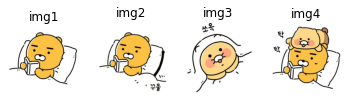

In [3]:
cv2.imshow('Img1', img1)
imgs = [img1, img2, img3, img4]
hists = []

for i, img in enumerate(imgs) :
    plt.subplot(1,len(imgs),i+1)
    plt.title('img%d'% (i+1))
    plt.axis('off') 
    plt.imshow(img[:,:,::-1])
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0,1], None, [180,256], [0,180,0, 256])
    cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)
    hists.append(hist)

query = hists[0]
methods = {'CORREL' :cv2.HISTCMP_CORREL, 'CHISQR':cv2.HISTCMP_CHISQR, 
           'INTERSECT':cv2.HISTCMP_INTERSECT,
           'BHATTACHARYYA':cv2.HISTCMP_BHATTACHARYYA}
for j, (name, flag) in enumerate(methods.items()):
    print('%-10s'%name, end='\t')
    for i, (hist, img) in enumerate(zip(hists, imgs)):
        ret = cv2.compareHist(query, hist, flag)
        if flag == cv2.HISTCMP_INTERSECT:
            ret = ret/np.sum(query)
        print("img%d:%7.2f"% (i+1 , ret), end='\t')
    print()
plt.show()

In [1]:
import cv2
import numpy as np

# 영상의 15%를 알파 블렌딩의 범위로 지정
alpha_width_rate = 15

# 합성할 두 영상 읽기
img_face = cv2.imread('./RC/1.jpg')
img_skull = cv2.imread('./RC/3.jpg')

# 입력 영상과 같은 크기의 결과 영상 준비
img_comp = np.zeros_like(img_face)

# 연산에 필요한 좌표 계산
height, width = img_face.shape[:2]
middle = width//2                             # 영상의 중앙 좌표
alpha_width = width * alpha_width_rate // 100 # 알파 블렌딩 범위
start = middle - alpha_width//2               # 알파 블렌딩 시작 지점
step = 100/alpha_width                        # 알파 값 간격

# 입력 영상의 절반씩 복사해서 결과 영상에 합성
img_comp[:, :middle, : ] = img_face[:, :middle, :].copy()
img_comp[:, middle:, :] = img_skull[:, middle:, :].copy()
cv2.imshow('half', img_comp)

# 알파 값을 바꾸면서 알파 블렌딩 적용
for i in range(alpha_width+1 ):
    alpha = (100 - step * i) / 100  # 증감 간격에 따른 알파 값 (1~0)
    beta = 1 - alpha                # 베타 값 (0~1)
    # 알파 블렌딩 적용
    img_comp[:, start+i] = img_face[:, start+i] * \
                                alpha + img_skull[:, start+i] * beta
    print(i, alpha, beta)
    
cv2.imshow('half skull', img_comp)
cv2.waitKey()
cv2.destroyAllWindows()

ValueError: could not broadcast input array from shape (785,497,3) into shape (508,287,3)

In [ ]:
# 모션 감지 CCTV (workshop_cctv_motion_sensor.py)

import cv2
import numpy as np

# 감도 설정(카메라 품질에 따라 조정 필요)
thresh = 25    # 달라진 픽셀 값 기준치 설정
max_diff = 5   # 달라진 픽셀 갯수 기준치 설정

# 카메라 캡션 장치 준비
a, b, c = None, None, None
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 480)      # 프레임 폭을 480으로 설정 
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 320)     # 프레임 높이를 320으로 설정

if cap.isOpened():
    ret, a = cap.read()         # a 프레임 읽기
    ret, b = cap.read()         # b 프레임 읽기

    while ret:
        ret, c = cap.read()     # c 프레임 읽기
        draw = c.copy()         # 출력 영상에 사용할 복제본
        if not ret:
            break
        
        # 3개의 영상을 그레이 스케일로 변경
        a_gray = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
        b_gray = cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)
        c_gray = cv2.cvtColor(c, cv2.COLOR_BGR2GRAY)

        # a-b, b-c 절대 값 차 구하기 
        diff1 = cv2.absdiff(a_gray, b_gray)
        diff2 = cv2.absdiff(b_gray, c_gray)

        # 스레시홀드로 기준치 이내의 차이는 무시
        ret, diff1_t = cv2.threshold(diff1, thresh, 255, cv2.THRESH_BINARY)
        ret, diff2_t = cv2.threshold(diff2, thresh, 255, cv2.THRESH_BINARY)

        # 두 차이에 대해서 AND 연산, 두 영상의 차이가 모두 발견된 경우
        diff = cv2.bitwise_and(diff1_t, diff2_t)

        # 열림 연산으로 노이즈 제거 ---①
        k = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
        diff = cv2.morphologyEx(diff, cv2.MORPH_OPEN, k)

        # 차이가 발생한 픽셀이 갯수 판단 후 사각형 그리기
        diff_cnt = cv2.countNonZero(diff)
        if diff_cnt > max_diff:
            nzero = np.nonzero(diff)  # 0이 아닌 픽셀의 좌표 얻기(y[...], x[...])
            cv2.rectangle(draw, (min(nzero[1]), min(nzero[0])), \
                                (max(nzero[1]), max(nzero[0])), (0,255,0), 2)
            cv2.putText(draw, "Motion Detected", (10,30), \
                                cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255))
        
        # 컬러 스케일 영상과 스레시홀드 영상을 통합해서 출력
        stacked = np.hstack((draw, cv2.cvtColor(diff, cv2.COLOR_GRAY2BGR)))
        cv2.imshow('motion sensor',stacked )

        # 다음 비교를 위해 영상 순서 정리
        a = b
        b = c
        
        if cv2.waitKey(1) & 0xFF == 27:
            break          